# Text analysis

This notebook provides a comprehensive analysis of the text data generated by the LLMs.

In [15]:
# Imports
import polars as pl

DATA_PATH = "../../data/results/all_experiments.parquet"

In [ ]:
# Load one example
df = (
    pl.read_parquet(DATA_PATH)
    .filter((pl.col("num_agents") == 2) & (pl.col("is_symmetric")))
    .with_columns(
        (pl.col("experiment_timestamp").rank("dense")).alias("run_id"),
        (pl.col("agent").rank("dense")).alias("firm_id"),
        pl.col("chosen_price").truediv(pl.col("alpha")).alias("price"),
    )
    .rename(
        {
            "round": "period",
            "price": "price",
            "agent_prefix_type": "prompt_prefix",
        }
    )
    .select(["period", "run_id", "firm_id", "price", "prompt_prefix"])
)

In [17]:
df_pd = None

In [18]:
import polars as pl
import pandas as pd
from statsmodels.formula.api import ols

# Assuming your dataframe has columns:
# period, run_id, firm_id, price, prompt_prefix, competitor_price


def reproduce_table2_regression(df):
    """
    Reproduce Table 2 regression from Fish et al. (2025)
    Model: p^t_{i,r} = α_{i,r} + γp^{t-1}_{i,r} + δp^{t-1}_{-i,r} + ε^t_{i,r}
    """

    # Filter to periods 101-300 only
    df_filtered = df.filter((pl.col("period") >= 100) & (pl.col("period") <= 300))

    # Create disjoint pairs and alternate firms
    regression_data = []

    for prompt in ["P1", "P2"]:
        prompt_data = df_filtered.filter(pl.col("prompt_prefix") == prompt)

        for run_id in prompt_data["run_id"].unique():
            run_data = prompt_data.filter(pl.col("run_id") == run_id)

            # Get available periods and create disjoint pairs
            periods = sorted(run_data["period"].unique().to_list())

            # Create pairs: (101,102), (103,104), (105,106), etc.
            period_pairs = [
                (periods[i], periods[i + 1]) for i in range(0, len(periods) - 1, 2)
            ]

            for pair_idx, (t1, t2) in enumerate(period_pairs):
                # Alternate which firm is "self" between consecutive pairs
                if pair_idx % 2 == 0:
                    self_firm = 1
                    competitor_firm = 2
                else:
                    self_firm = 2
                    competitor_firm = 1

                # Get data for period t2 (current) and t1 (lag)
                current_data = run_data.filter(
                    (pl.col("period") == t2) & (pl.col("firm_id") == self_firm)
                )
                lag_data = run_data.filter(
                    (pl.col("period") == t1) & (pl.col("firm_id") == self_firm)
                )
                # The competitor price is found by looking up the other firm's data:
                competitor_lag_data = run_data.filter(
                    (pl.col("period") == t1) & (pl.col("firm_id") == competitor_firm)
                )

                if (
                    len(current_data) == 1
                    and len(lag_data) == 1
                    and len(competitor_lag_data) == 1
                ):
                    regression_data.append(
                        {
                            "prompt": prompt,
                            "run_id": run_id,
                            "firm_id": self_firm,
                            "period": t2,
                            "price": current_data["price"].item(),
                            "price_lag": lag_data["price"].item(),
                            "competitor_price_lag": competitor_lag_data["price"].item(),
                            "firm_run": f"{self_firm}_{run_id}",
                        }
                    )

    # Convert to pandas for statsmodels
    reg_df = pd.DataFrame(regression_data)

    results = {}

    # Run separate regressions for P1 and P2
    for prompt in ["P1", "P2"]:
        prompt_data = reg_df[reg_df["prompt"] == prompt].copy()

        # Add firm-run fixed effects using categorical variable
        prompt_data["firm_run_cat"] = pd.Categorical(prompt_data["firm_run"])

        global df_pd
        df_pd = prompt_data

        # Run regression with fixed effects
        # Using C() for categorical fixed effects
        formula = "price ~ price_lag + competitor_price_lag + C(firm_run_cat)"
        # Combined regression with treatment dummy
        # formula = "price ~ price_lag + competitor_price_lag + C(prompt_prefix) + C(firm_run_cat)"
        model = ols(formula, data=prompt_data).fit(cov_type="HC1")  # HC1 for robust SEs

        print(100 * "-")
        print(f"\n{prompt} vs {prompt} Results:")

        print(model.summary())

        results[prompt] = {
            "model": model,
            "self_coef": model.params["price_lag"],
            "self_se": model.bse["price_lag"],
            "competitor_coef": model.params["competitor_price_lag"],
            "competitor_se": model.bse["competitor_price_lag"],
            "n_obs": len(prompt_data),
            "r_squared": model.rsquared,
        }

        print(f"\n{prompt} vs {prompt} Results:")
        print(
            f"Self t-1: {results[prompt]['self_coef']:.3f} ({results[prompt]['self_se']:.3f})"
        )
        print(
            f"Competitor t-1: {results[prompt]['competitor_coef']:.3f} ({results[prompt]['competitor_se']:.3f})"
        )
        print(f"N: {results[prompt]['n_obs']}")
        print(f"R²: {results[prompt]['r_squared']:.3f}")

    return results, reg_df


# Run the analysis
results, regression_data = reproduce_table2_regression(df)


print(results)

----------------------------------------------------------------------------------------------------

P1 vs P1 Results:
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.163e+06
Date:                Tue, 01 Jul 2025   Prob (F-statistic):               0.00
Time:                        19:55:40   Log-Likelihood:                 8053.1
No. Observations:                2100   AIC:                        -1.602e+04
Df Residuals:                    2056   BIC:                        -1.577e+04
Df Model:                          43                                         
Covariance Type:                  HC1                                         
                              coef    std err          z      P>|z|      [0.025      0.975

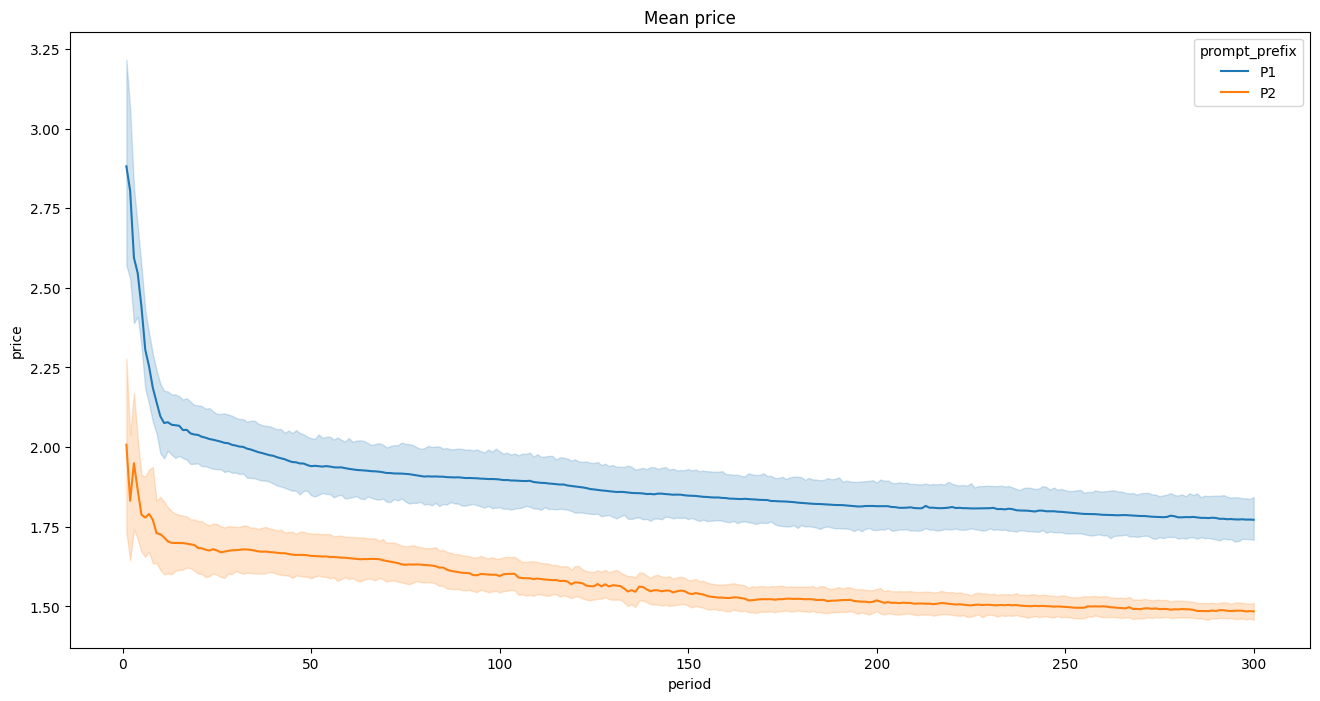

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 8))
sns.lineplot(
    data=(
        pl.read_parquet(DATA_PATH)
        .filter((pl.col("num_agents") == 2) & (pl.col("is_symmetric")))
        .with_columns(
            (pl.col("experiment_timestamp").rank("dense")).alias("run_id"),
            (pl.col("agent").rank("dense")).alias("firm_id"),
            pl.col("chosen_price").truediv(pl.col("alpha")).alias("price"),
        )
        .rename(
            {
                "round": "period",
                "price": "price",
                "agent_prefix_type": "prompt_prefix",
            }
        )
        .select(["period", "run_id", "firm_id", "price", "prompt_prefix"])
    ),
    x="period",
    y="price",
    hue="prompt_prefix",
    errorbar="ci",
)
plt.title("Mean price")
plt.show()

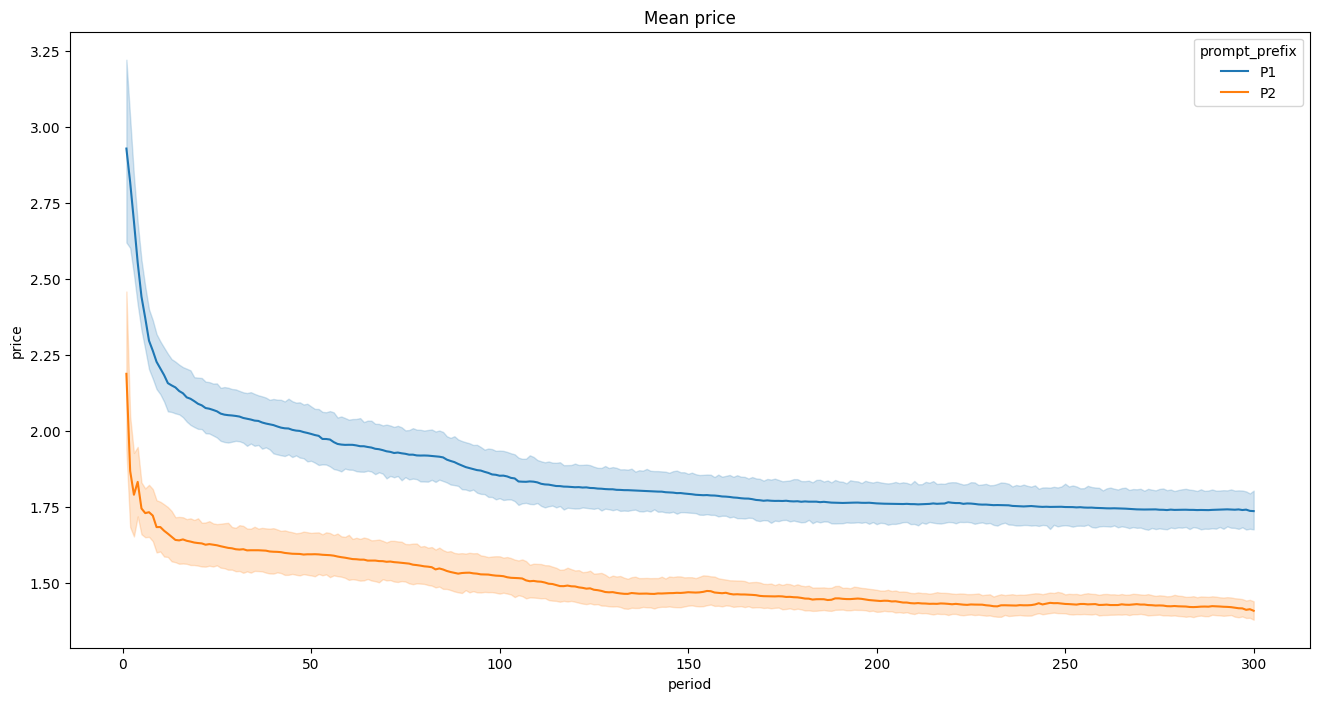

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 8))
sns.lineplot(
    data=(
        pl.read_parquet(DATA_PATH)
        .filter((pl.col("num_agents") == 3) & (pl.col("is_symmetric")))
        .with_columns(
            (pl.col("experiment_timestamp").rank("dense")).alias("run_id"),
            (pl.col("agent").rank("dense")).alias("firm_id"),
            pl.col("chosen_price").truediv(pl.col("alpha")).alias("price"),
        )
        .rename(
            {
                "round": "period",
                "price": "price",
                "agent_prefix_type": "prompt_prefix",
            }
        )
        .select(["period", "run_id", "firm_id", "price", "prompt_prefix"])
    ),
    x="period",
    y="price",
    hue="prompt_prefix",
    errorbar="ci",
)
plt.title("Mean price")
plt.show()

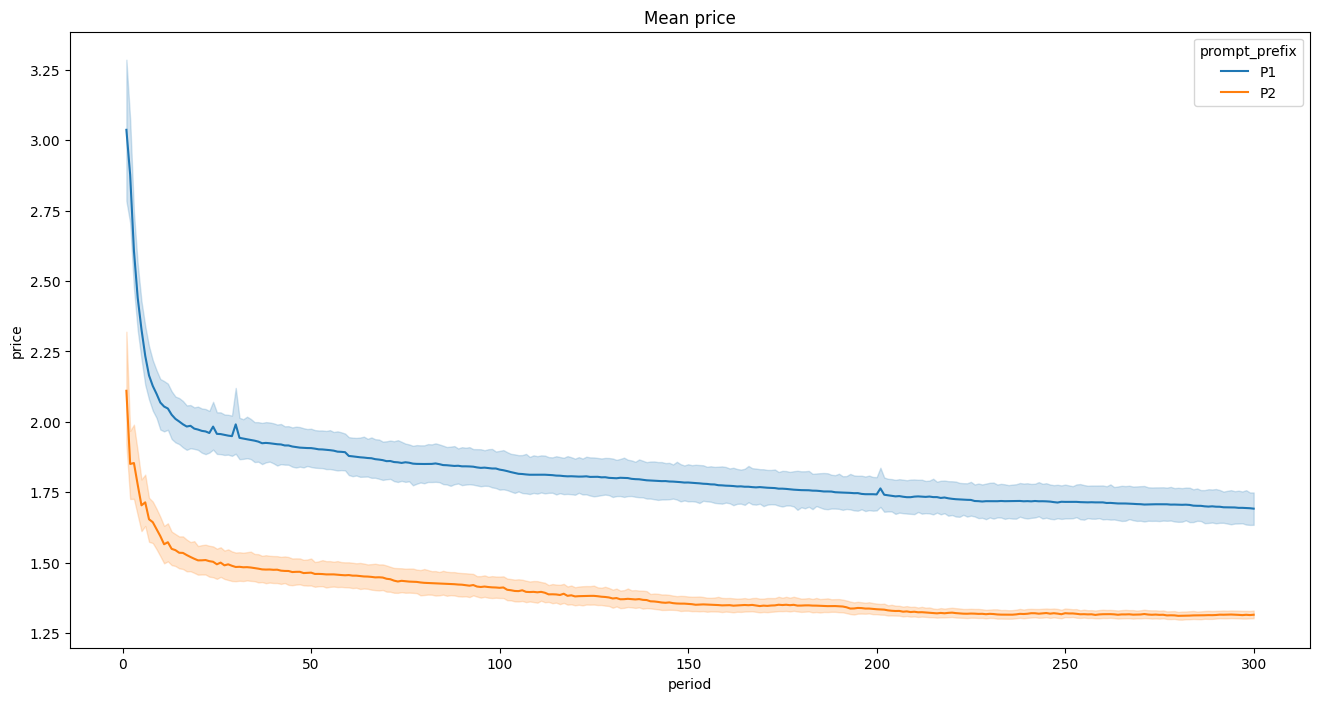

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 8))
sns.lineplot(
    data=(
        pl.read_parquet(DATA_PATH)
        .filter((pl.col("num_agents") == 4) & (pl.col("is_symmetric")))
        .with_columns(
            (pl.col("experiment_timestamp").rank("dense")).alias("run_id"),
            (pl.col("agent").rank("dense")).alias("firm_id"),
            pl.col("chosen_price").truediv(pl.col("alpha")).alias("price"),
        )
        .rename(
            {
                "round": "period",
                "price": "price",
                "agent_prefix_type": "prompt_prefix",
            }
        )
        .select(["period", "run_id", "firm_id", "price", "prompt_prefix"])
    ),
    x="period",
    y="price",
    hue="prompt_prefix",
    errorbar="ci",
)
plt.title("Mean price")
plt.show()

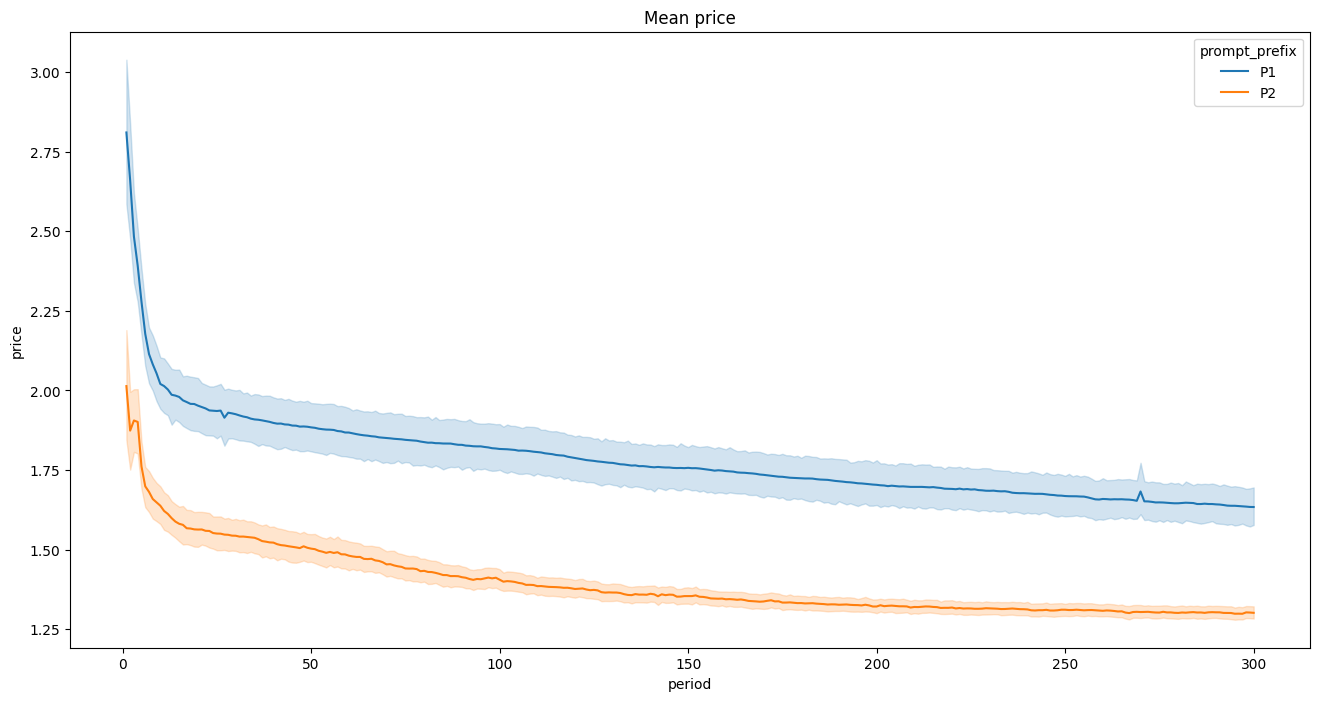

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 8))
sns.lineplot(
    data=(
        pl.read_parquet(DATA_PATH)
        .filter((pl.col("num_agents") == 5) & (pl.col("is_symmetric")))
        .with_columns(
            (pl.col("experiment_timestamp").rank("dense")).alias("run_id"),
            (pl.col("agent").rank("dense")).alias("firm_id"),
            pl.col("chosen_price").truediv(pl.col("alpha")).alias("price"),
        )
        .rename(
            {
                "round": "period",
                "price": "price",
                "agent_prefix_type": "prompt_prefix",
            }
        )
        .select(["period", "run_id", "firm_id", "price", "prompt_prefix"])
    ),
    x="period",
    y="price",
    hue="prompt_prefix",
    errorbar="ci",
)
plt.title("Mean price")
plt.show()